In [1]:
%load_ext autoreload
%autoreload plotmport numpy as np
import pandas as pd
import pandas_bokeh

import mlfinlab as mfl

import polygon_backfill as pb
import market_cluster as mc
import s3_datasets as s3d
import filters as ft
import local_backfill as lb

symbol='GLD'
date='2020-08-27'
result_path='/Users/bobcolner/QuantClarity/pandas-polygon/data'

# .plot_bokeh(kind='hist', bins=50, sizing_mode="scale_height", disable_scientific_axes=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)

In [153]:
def get_ticks(symbol, date, result_path):
    
    try:
        df = pd.read_feather(result_path+f'/trades/feather/symbol={symbol}/date={date}/data.feather')
    except:
        lb.backfill_date_tofile(symbol, date, tick_type='trades', result_path=result_path)
        df = pd.read_feather(result_path+f'/trades/feather/symbol={symbol}/date={date}/data.feather')    

    # add dt diff
    df['dt_diff'] = (df.sip_dt - df.exchange_dt)
    # drop trade conditions
    df = df[df.irregular==False].reset_index(drop=True)
    # drop ts gap trades
    df = df[df.dt_diff < pd.to_timedelta(1, unit='S')].reset_index(drop=True)
    # add median filter and remove outlier trades
    df['filter'] = df['price'].rolling(window=5, center=False, min_periods=1).median()
    df['filter_diff'] = abs(df['price'] - df['filter'])
    df['filter_pct'] = abs((1-(df['filter_diff'] / df['price'])))*100
    df['filter_zs'] = (df['filter_diff'] - df['filter_diff'].mean()) / df['filter_diff'].std(ddof=0)
    df = df[df.filter_zs < 10].reset_index(drop=True)
    # sort df
    df = df.sort_values(['sip_dt', 'exchange_dt', 'sequence'])
    # add price filters
    df = ft.add_filters(df, 'price')
    return(df)

# ['sip_dt', 'exchange_dt', 'size', 'price', 'filter_zs']
# .describe(percentiles=[.99,.999,.9999])

In [154]:
df = get_ticks(symbol, date, result_path)

<AxesSubplot:>

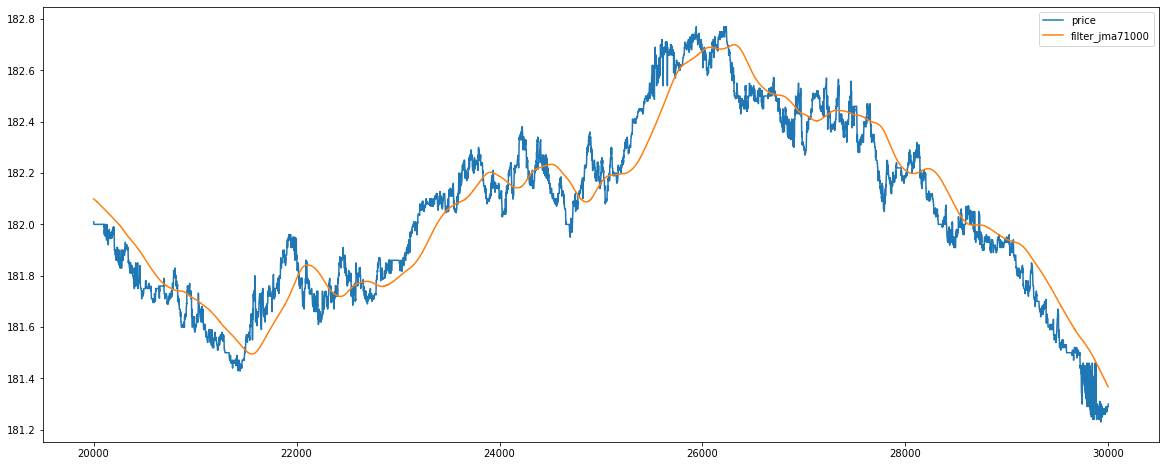

In [73]:
df[['price', 'filter_jma710']][20000:30000].plot(figsize=[20,8])
# df[['price', 'filter_jma71000']][20000:30000].plot_bokeh(kind='line', sizing_mode="scale_height", disable_scientific_axes=True)

In [225]:
df2 = df.rename(columns={'sip_dt': 'date_time', 'size': 'volume'})

df2 = df2[['date_time', 'price', 'volume']]

In [277]:
bars = mfl.data_structures.get_tick_bars(df2, threshold=1000)

Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
!pip show mlfinlab

In [251]:
bars, thresh = mfl.data_structures.get_const_tick_imbalance_bars(df2, expected_imbalance_window=100000, exp_num_ticks_init=10000)

Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
# get data from s3
clean_df, bad_df = s3d.get_s3_df(symbol, date)

# list_s3_symbol('SPY')
df = s3d.get_s3_df('GLD', '2020-08-27', columns=['exchange_epoch', 'price', 'size', 'condition'])
# df = s3d.get_s3_df(symbol='SPY', date='2020-08-28', columns=['exchange_epoch', 'price', 'size', 'condition'])

# df = pd.read_feather('data.feather', columns=['exchange_epoch', 'price', 'size', 'condition'])
# df['date_time'] = pd.to_datetime(df.exchange_epoch)

In [ ]:
# get local market daily data
mdf = pd.read_parquet('data/mdf.parquet')

sdf = mdf[mdf.symbol=='SPY']

In [ ]:
### market clustering

# %time df = read_market_daily(result_path)
%time mdf = pd.read_parquet('data/mdf.parquet')

%time npdf, sharpe_ratios = mc.normalize_market_df(mdf)

# %time npdf_resid = colwise_linreg(npdf)
%time npdf_resid = pd.read_parquet('data/npdf_resid.parquet')

# %time par_cor_mat = npdf_resid.corr()
%time resid_par_cor_mat = pd.read_parquet('data/partial_cor_mat.parquet')

%time details_df = pd.read_parquet('data/details_df.parquet')

# cluster_lables = cluster_sim_matrix(similarity=resid_par_cor_mat.abs())
%time cluster_lables = pd.read_parquet('data/cluster_lables.parquet')

# symbol_meta = join_symbol_data(details_df, cluster_lables, sharpe_ratios, mdf)
%time symbol_meta = pd.read_parquet('data/symbol_meta.parquet')

# cluster_coheasion = mc.get_cluster_coheasion(sim_df=resid_par_cor_mat.abs(), symbol_meta=symbol_meta, cluster_col='cluster_n200')

In [ ]:
symbol_meta['liquidy_rank'] = symbol_meta.groupby('cluster_n200')['daily_avg_dollar_volume'].rank(method='first')

symbol_meta = symbol_meta.sort_values(['cluster_n200', 'liquidy_rank']).reset_index()

In [ ]:
by_cluster = symbol_meta.groupby('cluster_n200')
result = []
for cluster, frame in by_cluster:
    counts = dict(frame['sector'].value_counts())
    counts.pop('', None)  # drop symbols w/o sector/industry info
    result.append(counts)

cluster_sec = pd.DataFrame(result)    
cluster_sec = cluster_sec.drop(columns=['Finance'])
cluster_sec_pct = cluster_sec.apply(lambda x: 100 * x / float(x.sum()), axis=1)

In [ ]:
cluster_sec_pct.style.background_gradient(cmap='coolwarm', axis=0)

In [ ]:
# n += 1
n = 61
print(n)
symbol_meta[symbol_meta.cluster_n200==n].sector.value_counts()

In [ ]:
sym_clust = symbol_meta[symbol_meta.cluster_n200==n]
sym_clust